## Load these specific libraries

In [1]:
import tensorflow as tf #ml models
import numpy as np #array operations and saving files with pickle format
import os #operative system
import PIL #play with images
from PIL import Image
import json #read from json file
import random 
import collections #were I use defauldict(list) -> initialize all instances of a dict with a list
import matplotlib.pyplot as plt #plot graphics

## Connect to Google Drive

In [2]:
#Start by connecting gdrive into the google colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load the MS-COCO Dataset

**Caution: large download ahead**. I'm using the training set, which is a 13GB file.

[web-site](https://cocodataset.org/#home)

In [3]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 325s 0us/step


This part is **Optional**:

> Limit the size of the training set. To speed up training I'll use a subset of approximately 30,000 captions and their corresponding images to train the model. Choosing to use more data would result in improved captioning quality.




In [5]:
with open(annotation_file, 'r') as f:
    #oll of the captions are loaded here
    annotations = json.load(f)

In [6]:
#Group all captions together having the same image ID.
#Returns a new dictionary-like object. defaultdict is a subclass of the built-in dict class. 
#Instantiate each instace as a list - []
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  #'%012d.jpg' serves to transform the image_id into a 12 number digit to mimic the structure of image names
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [7]:
#each key is the image file
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will 
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [8]:
#each image as 5 captions approximately, so lets map each image with one caption
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  #pushes X times an image to the list, where X = number of captions
  img_name_vector.extend([image_path] * len(caption_list))

<start> a close up of a person messing with an analog clock <end>


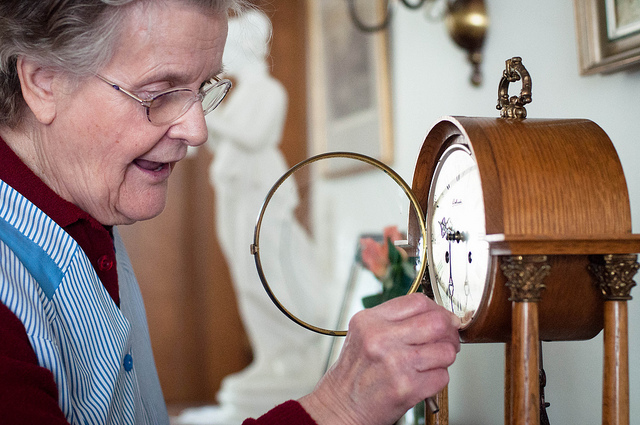

In [9]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocess the images using InceptionV3

> Do not forget that when using inceptionV3 preprocessing function to transform the inputs according to the model, it changes the real data into the **disk(or RAM)** depending where you are storing the files. 

> So, after this transformation save the files again into **pickle** format

In [10]:
def read_image(image_path):
  #return a the content file in bytes format
  content = tf.io.read_file(image_path)
  #We know that the image as extension jpeg so use this function. Otherwise the shapes wont be traced by the function
  img = tf.image.decode_jpeg(content, channels=3)
  img = tf.image.resize(img,(299,299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path



## Initialize InceptionV3 and load the pretrained Imagenet weights

> I will use all the layers except the last one

In [11]:
inception = tf.keras.applications.InceptionV3(
    include_top = False,
    weights = 'imagenet',
    input_shape = (299,299,3)
)

model = tf.keras.models.Model( inputs = inception.input , outputs = inception.layers[-1].output)
print(f"Last output = {model.output}")

87916544/87910968 [==============================] - 1s 0us/step
Last output = KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 2048), dtype=tf.float32, name=None), name='mixed10/concat:0', description="created by layer 'mixed10'")


## Caching the features extracted from InceptionV3
I'll pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 * 8 * 2048 floats per image. This will probably exceeds the memory limitations of Colab/local pc.

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, use **tdqm** like I do

In [12]:
!pip install tqdm
from tqdm import tqdm

In [13]:
#Get unique images
encode_train = sorted(set(img_name_vector))

batch = 16
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch)

for img, path in tqdm(image_dataset):
  batch_features = model(img)
  #this will return (batch_size, 8, 8, 2048)
  #Reshape will ensure that we transform (8,8,2048) into a (8*8,2048) dense representation. Like the Flatten method
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 375/375 [01:29<00:00,  4.20it/s]


## Preprocess and tokenize the captions

In [14]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = Tokenizer(num_words=top_k,
                      oov_token="<unk>",
                      filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)

In [16]:
word_index = tokenizer.word_index
index_word = tokenizer.index_word

word_index['<pad>'] = 0
index_word[0] = '<pad>'

In [17]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [18]:
# Pad each vector to the max_length of the captions
# If one does not provide a max_length value for the padding, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [19]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
print(f"Max sentence length is of = {max_length}")

Max sentence length is of = 49


## Split the data into training and testing

In [20]:
#We need to make another dictionary to map each image to the according padded captions
img_to_cap_vector = collections.defaultdict(list)

#image and the padding caption
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

#80% for training and 20% for validation
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]


#Loading training data
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

#Loading validation data
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [21]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24009, 24009, 6002, 6002)

## Create a tf.data dataset for training
> The images and captions are ready. Each one is mapped and are stored into two lists. 
> Create a tf.data dataset to use for training our model.

In [22]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64
vocab_size = top_k + 1

In [23]:
# Load the numpy files
# This function reads the dense vectors produced by the inception model
# They were save as npy files, so we need to transoform this function into a tensorflow function, to make use of td.data.Dataset map functions
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [24]:
#each tuple has the image and the padded caption
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel and transform into a tensorflow function
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          #use num_parallel_calls to read images in parallel
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
for image,caption in dataset.take(1):
  print(image.shape)
  print(caption.shape)

(64, 64, 2048)
(64, 49)


## Model
**Fun fact:** the decoder below is identical to the one in the example for Neural Machine Translation with Attention.

The model architecture is inspired by the [Show, Attend and Tell paper](https://arxiv.org/pdf/1502.03044.pdf)

In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
You squash that to a shape of (64, 2048).
This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
The RNN (here GRU) attends over the image to predict the next word.



In [26]:
class BahdanauAttention(tf.keras.models.Model):
  def __init__(self,units,**kargs):
    super(**kargs).__init__()
    
    self.W1 = tf.keras.layers.Dense(units=units)
    self.W2 = tf.keras.layers.Dense(units=units)
    self.attention = tf.keras.layers.Dense(1)


  def call(self, query, values):
    #values represent the features of (CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    #query is the specific embeded word that we received -> it has a shape of (batch, embeded_vector)
    #expand the dimensions so that matches with values shape -> now the shape is (batch, 1, embeded_vector)
    query_expanded = tf.expand_dims(query,axis=1)

    #hidden layer after concatenating the query and values, this is the scores
    attention_hidden_layer = tf.nn.tanh(tf.add(self.W1(query_expanded), self.W2(values)))

    #now we compute the attention weights
    #shape from (batch,64,units) to (batch,64,1)
    attention_weights = self.attention(attention_hidden_layer)

    #normalized attention weights in the first axis -> shape of (batch,64,units)
    normalized_attention_weights = tf.nn.softmax(attention_weights,axis=1)

    #context vector where we multiply each attention by its according vector
    #shape = (batch,64,embedding_dim) * (batch,64,1) = (batch,64,embedding_dim)
    context_vector = values * normalized_attention_weights
    #then we reduce sum every weighted sum element in the middle axis
    context_vector = tf.reduce_sum(context_vector,axis=1)



    return context_vector, attention_weights


In [27]:
class CNN_Encoder(tf.keras.Model):
    # Since I already extracted the features and dumped it using np.save and pickle
    # This encoder passes those features through a FCL
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [28]:
class RNN_Cell_Decoder(tf.keras.models.Model):
  def __init__(self, embedding_dim, vocab_size, units, **kargs):
    super(**kargs).__init__()

    self.units = units
    self.embedding_dim = embedding_dim
    self.vocab_size = vocab_size

    self.embedding = tf.keras.layers.Embedding(
        input_dim = self.vocab_size,
        output_dim = self.embedding_dim,
    )

    self.gru = tf.keras.layers.GRU(
        units = self.units,
        kernel_initializer = tf.keras.initializers.GlorotUniform(),
        return_sequences = True,
        return_state = True
    )

    self.fc1 = tf.keras.layers.Dense(units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  #x is the current word
  #hidden state is the query
  #features is the values
  def call(self, x, hidden_state, features):
    
    context_vector, attention_weights = self.attention(hidden_state,features)
  
    #x with shape of (batch,1,embedding_dim)
    x = self.embedding(x)

    #context vector has a shape of (batch,hidden_size), expand 1 unit before concatenating the two of them
    #now X has a shape of (batch,1,embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector,axis=1),x],axis=-1)
    
    gru_output , hidden_state = self.gru(x)

    #Now the classification part
    #this is one cell with word by word, so let's remove the middle axis
    x = self.fc1(gru_output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))
    
    out = self.fc2(x)

    return out, hidden_state , attention_weights
  
  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [29]:
embedding_dim = 128
units = 256
attention_features_shape = 64 # because in the inception model we get the final layer as (64,2048) -> this 64 represents the attention block

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Cell_Decoder(embedding_dim,vocab_size,units)

## Defining the loss function

In [30]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits = True,
    #the reduction used is None since we still have to perform masking, because of the paddding
    reduction = 'none'
)

def loss_function(real,pred):
  #This mask will return True and False, True when real = 0
  mask = tf.math.logical_not(tf.equal(real,0))
  loss = loss_object(real,pred)

  mask = tf.cast(mask, loss.dtype)
  loss *= mask

  return tf.math.reduce_mean(loss)
#tf.cast(tf.math.logical_not(tf.equal(tf.zeros(shape=(1,3)),0)),tf.float32)


## Creating CheckPoints to store and load the weights of both models
1. Encoder
2. Decoder

In [31]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           #optimizer saves import arguments such as the last learning rate, the decay, the epoch number and so on
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [32]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training
1. You extract the features stored in the respective .npy files and then pass those features through the encoder.
2.The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
3.The decoder returns the predictions and the decoder hidden state.
4.The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5.Use teacher forcing to decide the next input to the decoder.
6.Teacher forcing is the technique where the target word is passed as the next input to the decoder.
7.The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [33]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

### Try to change this in the future

> Instead of using all way during training **teacher forcing** try to alternate change it from forcing to using its **own predictions** at the midlle-end of training

In [34]:
@tf.function
def train_step(img_tensor,target):

  #initial state for the decoder cell
  hidden = decoder.reset_state(batch_size = target.shape[0])
  #the first word of each sentence is <start>, so encode it, since it's the first input
  x = tf.expand_dims([word_index['<start>']] * target.shape[0], 1 )

  loss = 0

  with tf.GradientTape() as tape:
    #img_tensor as shape of (1,64,128)
    features = encoder(img_tensor)

    #for each word
    for i in range(1,target.shape[1]):
      #feed the decoder the word the initial state (query) and the images(values)
      predictions, hidden, _ = decoder(x, hidden, features)
      #compute the loss
      loss += loss_function(target[:, i],predictions)
      # using teacher forcing
      x = tf.expand_dims(target[:, i], 1)


  total_loss = (loss / int (target.shape[1]))
  #variables used to train
  variables = encoder.trainable_variables + decoder.trainable_variables
  #compute gradients
  gradients = tape.gradient(loss,variables)
  #optimize the encoder + decoder
  optimizer.apply_gradients(zip(gradients,variables))

  return loss, total_loss


In [35]:
num_epochs = 30

for epoch in range(num_epochs):
  
  total_loss = 0

  for step,(img,target) in enumerate(dataset):
    batch_loss, t_loss = train_step(img, target)
    total_loss += t_loss

    if (step % 100 == 0):
      print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, step, batch_loss.numpy() / int(target.shape[1])))
            
  

  print(f"Epoch = {epoch+1} -- total loss = {total_loss/step}")

  loss_plot.append(total_loss/step)

  if epoch % 5 == 0:
      ckpt_manager.save()

Epoch 1 Batch 0 Loss 2.0451
Epoch 1 Batch 100 Loss 1.1875
Epoch 1 Batch 200 Loss 1.0904
Epoch 1 Batch 300 Loss 0.9805
Epoch = 1 -- total loss = 1.1335127353668213
Epoch 2 Batch 0 Loss 1.0189
Epoch 2 Batch 100 Loss 0.9543
Epoch 2 Batch 200 Loss 0.8761
Epoch 2 Batch 300 Loss 0.7590
Epoch = 2 -- total loss = 0.8686046600341797
Epoch 3 Batch 0 Loss 0.7962
Epoch 3 Batch 100 Loss 0.7373
Epoch 3 Batch 200 Loss 0.7481
Epoch 3 Batch 300 Loss 0.7675
Epoch = 3 -- total loss = 0.7773156762123108
Epoch 4 Batch 0 Loss 0.7739
Epoch 4 Batch 100 Loss 0.6890
Epoch 4 Batch 200 Loss 0.7801
Epoch 4 Batch 300 Loss 0.6440
Epoch = 4 -- total loss = 0.7238292098045349
Epoch 5 Batch 0 Loss 0.6449
Epoch 5 Batch 100 Loss 0.7323
Epoch 5 Batch 200 Loss 0.7629
Epoch 5 Batch 300 Loss 0.7149
Epoch = 5 -- total loss = 0.6966583132743835
Epoch 6 Batch 0 Loss 0.6979
Epoch 6 Batch 100 Loss 0.6702
Epoch 6 Batch 200 Loss 0.6229
Epoch 6 Batch 300 Loss 0.6290
Epoch = 6 -- total loss = 0.6597524285316467
Epoch 7 Batch 0 Loss 0

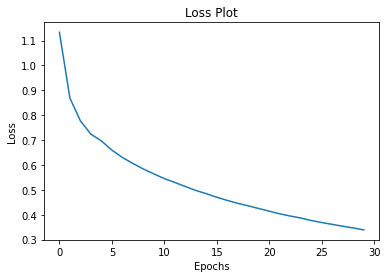

In [36]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption time!

**Adapted from TensorFlow**

1. The evaluate function is similar to the training loop, except you don't use teacher forcing here.
2. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
3. Stop predicting when the model predicts the end token.
And store the attention weights for every time step.



In [43]:
def evaluate(image):
    attention_plot = np.zeros((max_length, 64))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(read_image(image)[0], 0)
    img_tensor_val = model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    x = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(x, hidden, features)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(index_word[predicted_id])

        if index_word[predicted_id] == '<end>':
            return result, attention_plot

        x = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]

    return result, attention_plot

In [53]:
#image, predicted caption, attention plot with the corresponding attention weights
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> two zebra standing side by side next to a wall <end>
Prediction Caption: there are two zebras with mud in same jungle <end>


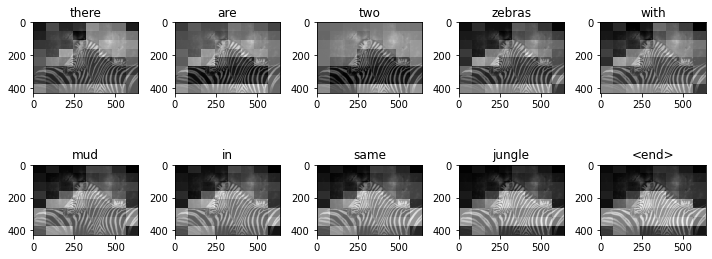

In [81]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Try it on your own images

Saving altice.jpg to altice (2).jpg
Prediction Caption: a man standing next to a picture outside <end>


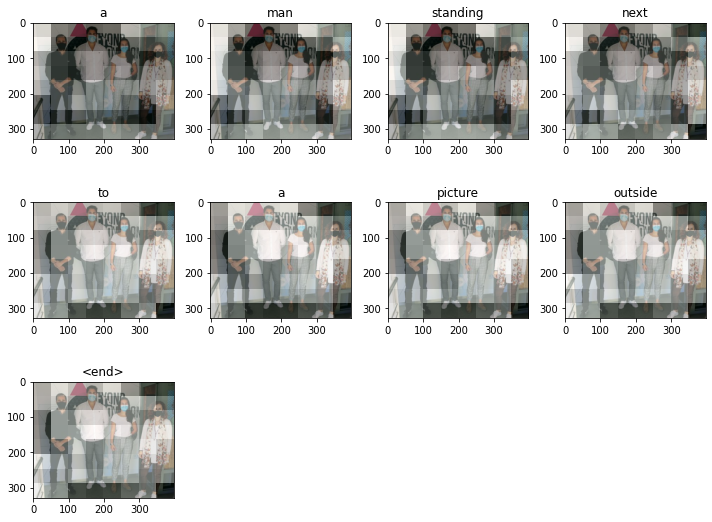

In [89]:
from keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for image in uploaded.keys():
  
  # captions on the image
  result, attention_plot = evaluate(image)

  print ('Prediction Caption:', ' '.join(result))
  plot_attention(image, result, attention_plot)
